# Keras LeNet Example

This example trains a LeNet model in Keras, and then imports the resulting trained model into SAS Viya, using DLPy.  The test image data is scored by both models and the model results are compared. The results show that the imported and converted SAS Viya model duplicates the results produced by the original Keras model. This demonstrates the consistency between the open-source Keras model and the imported and converted SAS Viya model.  

For best success before attempting this example in your own environment, consider reading Adrian Rosebrook's tutorial blog post on LeNet CNN models: https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python. The blog provides a nice summary of LeNet, and this example follows the blog's LeNet model definition.

## Important Note: Client and Server Definitions

SAS Viya literature and technical documentation often refers to client and server entities.  In this scenario, the client is the computer that runs the Jupyter notebook with the example code.  The server is the computer that is running the Viya server.  These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.  

This example assumes that the client and server do not use the same operating system, but that they do have access to a common file system.  If the client and server in your environment do not have access to a common file system, you will need to copy or transfer files between client and server twice during this example.  The example in this notebook uses comments in cells to indicate when a given file should be moved from the client to the server.

In [1]:
# define variables to contain path specifications to  
# the client and server machine image root directories
client_image_root = "<path/to/client/image/root>"  # this is the CLIENT_IMAGE_ROOT directory
server_image_root = "<path/to/server/image/root>"  # this is the SERVER_IMAGE_ROOT directory

## Import Python Function Packages


In [2]:
from __future__ import print_function

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import RMSprop
import os
from PIL import Image
import numpy as np

Using TensorFlow backend.


## Extract the Keras MNIST Image Classification Data

Use the MNIST data provided by Keras. For more information on the MNIST data, see https://keras.io/datasets/#mnist-database-of-handwritten-digits. Convenience functions provided by Keras load the data and assign labels to the training and test data.  There should be 60000 training images and 10000 test images.  Each image should be 28 pixels by 28 pixels.

In [3]:
num_classes = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# convert class vectors to binary class matrices - this effectively gives a classification
# label for each image
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Number of training images = " + str(x_train.shape[0]))
print("Number of test images = " + str(x_test.shape[0]))
print("Image size = " + str(x_train.shape[1]) + " x " + str(x_train.shape[2]))

Number of training images = 60000
Number of test images = 10000
Image size = 28 x 28


## Prepare Test Images Before Loading into SAS CAS / Viya


The test images for the example are stored in Python numpy arrays. There is not a direct way to convert a numpy array to a SAS CAS table, so the example first stores the test images in an intermediate PNG format. Afterwards, the example performs image processing actions and then loads the stored PNG images into a SAS CAS table.  Note that the action that loads images expects the following directory structure:

<br>
CLIENT_IMAGE_ROOT/label1
<br>
CLIENT_IMAGE_ROOT/label2
<br>
...
<br>
CLIENT_IMAGE_ROOT/labelN
<br>

In this instance, CLIENT_IMAGE_ROOT specifies the name of the root image directory on the client, and "label1", "label2", ..., "labelN" 
represents the N image classes.  All the images that belong to image class "label1" should reside in the CLIENT_IMAGE_ROOT/label1 directory, all the images that belong to image class "label2" should reside in the CLIENT_IMAGE_ROOT/label2 directory, and so on.

The MNIST image data contains 10 object classes. Each class is assigned a label "0", "1", ..., "9".  The example code assigns the test images to 10 separate directories as follows:

<br>
CLIENT_IMAGE_ROOT/0
<br>
CLIENT_IMAGE_ROOT/1
<br>
...
<br>
CLIENT_IMAGE_ROOT/9
<br>

Note: This example assumes that if the CLIENT_IMAGE_ROOT directory exists, then all image files have been unpacked and are ready for processing.

In [4]:
# check if working directory exists
if os.path.isdir(client_image_root):
    print("Image directory exists, assuming image files prepared for loading into CAS table")
else:
    os.mkdir(client_image_root)
    
    # create subdirectories for each image class
    for ii in range(10):
        new_path = os.path.join(client_image_root,str(ii))
        if not os.path.isdir(new_path):
            os.mkdir(new_path)

    # distribute images to proper directories
    im_index = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for ii in range(x_test.shape[0]):
        im = Image.fromarray(x_test[ii,])
        idx = np.where(y_test[ii])[0][0]
        file_name = 'im'+str(idx)+'_file'+str(im_index[idx])+'.png'
        new_path = os.path.join(client_image_root,str(idx))
        im.save(os.path.join(new_path,file_name))
        im_index[idx] = im_index[idx] + 1

Image directory exists, assuming image files prepared for loading into CAS table


In [5]:
# If your client/server do not share a common file system, please copy the image files and subdirectories from CLIENT_IMAGE_ROOT to 
# SERVER_IMAGE_ROOT.

## Data Pre-processing

The following code converts the image data to floating point and scales it such that all pixel values fall within the range 0.0 to 1.0.


In [6]:
# Scale the 60,000 train images and the 10,000 test images.
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Define the Keras LeNet Model Architecture

In [7]:
# Define the Architecture for a Keras LeNet 
# Image Classification Model

# training parameters
batch_size = 128
epochs = 1

# model architecture and activation functions
model = Sequential()
model.add(Conv2D(20, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28,28,1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Conv2D(50, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# print a model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1225500   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5010      
Total para

## Provide Trained LeNet Model Parameters

After you define the Keras LeNet model architecture, you must either train the model from scratch, or you can supply the model with an archived set of trained model parameters in HDF5 format. In this instance we load the model with trained parameters as defined in the file CLIENT_IMAGE_ROOT/lenet.h5. 

If you want to train the model from scratch, set the value for the do_train parameter to True. To load pretrained model parameters saved in an HDF5 file, set the value for the do_train parameter to False.

In [8]:
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

# Set the LeNet model do_train parameter to False
# and supply the model with a pretrained parameter 
# file named "lenet.h5".

do_train = False
if do_train:
    history = model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test))
    
    model.save(os.path.join(client_image_root,"lenet.h5"))
else:    
    # Load the previously trained parameter file "lenet.h5" in lieu
    # of training the LeNet model from scratch.
    model.load_weights(os.path.join(client_image_root,"lenet.h5"))

# Now use the trained model to score the test Data.
    
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])    

Test loss: 0.12472512652352452
Test accuracy: 0.9601


## Connect to the SAS CAS Server

In [9]:
# Configure matplotlib utility to display output in 
# Jupyter notebook cell
%matplotlib inline

# SAS Scripting Wrapper for Analytic Transfer (SWAT)
# is a module needed to connect to a CAS server.
from swat import * 

# start SAS CAS session
s = CAS("<CAS server IP address>", <port number>)

## Convert the Keras Model to a SAS Viya Model

Two operations take place when the from_keras_model() function is called. The first operation automatically translates the Keras model into a SAS Deep Learning model.  You can perform this process manually, but it is not recommended because it is error-prone and time-consuming.  

The second operation rearranges and reformats the HDF5 parameter file that was generated by Keras.  Rearranging and reformatting the parameter file enables the SAS Deep Learning action set to correctly parse and read the trained parameters. 

In [10]:
from dlpy import Model
# Convert the Keras model to a SAS Viya model
# Convert Keras model parameters to a format 
# that can be read by SAS DLPy and the SAS 
# Deep Learning toolkit.
model_name = 'lenet'
model1 = Model.from_keras_model(conn=s, keras_model=model, output_model_table=model_name,
                               include_weights=True, scale=1.0/255.0,
                               input_weights_file=os.path.join(client_image_root,"lenet.h5"))

NOTE: Added action set 'deeplearn'.
NOTE: Model table is attached successfully!
NOTE: Model is named to "lenet" according to the model name in the table.
NOTE: the model weights has been stored in the following file:
lenet_weights.kerasmodel.h5


## Copy the Reformatted HDF5 File

This is for convenience, in the event that your client and server share a common file system.  If there is no common file system, then you must perform a copy operation to transfer the HDF5 file from one file system to another.  Remember that deep learning HDF5 files can be quite large, so the data transfer could take a significant amount of time.

In [11]:
from shutil import copyfile
copyfile('lenet_weights.kerasmodel.h5', os.path.join(client_image_root,"lenet_weights.kerasmodel.h5"))

'lenet_weights.kerasmodel.h5'

## Populate the SAS Viya Model with Trained Parameters

Up to this point, the SAS Viya model contains parameters that were initialized according to the default settings supplied when the model was created in the preceding step. Now we will import the trained parameters from the Keras model and install them into the SAS Viya model. 

It is also a good idea at this time to apply labels to the output of the classification layer. The layers should be consistent with the labels that we will shortly apply to the test images.

In [12]:
model1.load_weights(path=server_image_root+"/lenet_weights.kerasmodel.h5",
                    labels=True,
                    label_file_name=os.path.join(os.getcwd(),"mnist_labels.csv"),
                    label_length=1)

NOTE: Cloud Analytic Services made the uploaded file available as table NEW_LABEL_TABLE_PBN9HI in caslib CASUSER.
NOTE: The table NEW_LABEL_TABLE_PBN9HI has been created in caslib CASUSER from binary data uploaded to Cloud Analytic Services.
NOTE: no dataspec(s) provided - creating image classification model.
NOTE: Model weights attached successfully!


## Summarize the SAS Viya Model Architecture

Please compare the SAS Viya model architecture and parameter count in this summary to the model architecture and parameter count from the Keras model above. The model layers and model layer definitions may differ somewhat between the Keras and SAS Viya models, but the total number of trained parameters in the two models should be identical.

In [13]:
model1.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,0,conv2d_1_input,input,,,None,"(28, 28, 1)","(0, 0)"
1,1,conv2d_1,convo,"(5, 5)",1,Rectifier,"(28, 28, 20)","(500, 20)"
2,2,max_pooling2d_1,pool,"(2, 2)",2,Max,"(14, 14, 20)","(0, 0)"
3,3,conv2d_2,convo,"(5, 5)",1,Rectifier,"(14, 14, 50)","(25000, 50)"
4,4,max_pooling2d_2,pool,"(2, 2)",2,Max,"(7, 7, 50)","(0, 0)"
5,5,dense_1,fc,"(2450, 500)",,Rectifier,500,"(1225000, 500)"
6,6,dense_2,output,"(500, 10)",,Softmax,10,"(5000, 10)"
7,,,,,,,,1256080


## Load the MNIST Image Classification Test Data

You will need to provide a path to your environment's server path in order to load the MNIST test data images. This example uses a path placeholder called SERVER_IMAGE_ROOT. Your path will be different.

In [14]:
# import SAS DLPy simple image processing functions
from dlpy.images import ImageTable

# load the MNIST image classification model test data images
my_images = ImageTable.load_files(s, path=server_image_root)

## Verify Appearance of Test Data Images

After loading the MNIST model test data images into the SAS Viya model in DLPy, display a matrix of 8 random images arranged in 4 columns. Verify that the test images resemble various hand-written Arabic numerals.

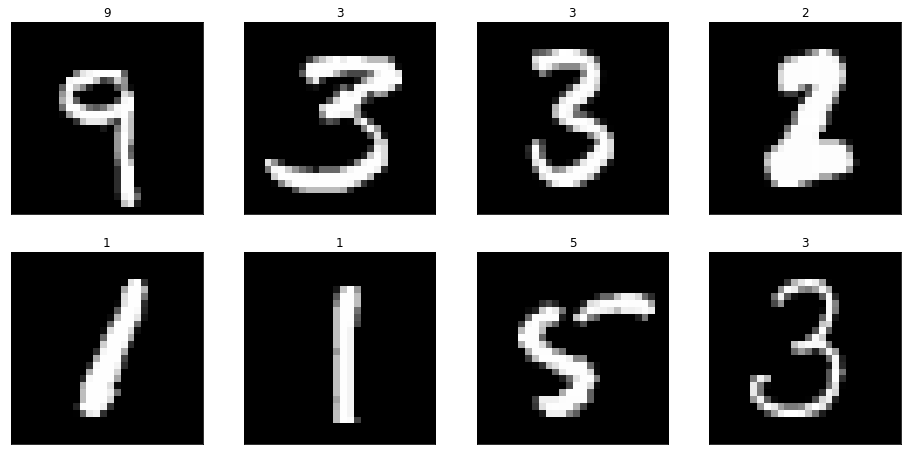

In [15]:
my_images.show(nimages=8,ncol=4, randomize=True)

## Score the Test Images with the Viya Model

Now use the SAS Viya classification model to score the test images.

In [16]:
# score images
viya_score = model1.predict(my_images, buffer_size=batch_size, n_threads=1)
print(viya_score['ScoreInfo'])

                         Descr         Value
0  Number of Observations Read         10000
1  Number of Observations Used         10000
2  Misclassification Error (%)          3.99
3                   Loss Error      0.124725


## Verify the Results

Compare the classification results generated by the Keras model and the imported SAS Viya model.
These results should be identical or nearly so.  Note that the Keras model reports classification rate, while the SAS Viya model reports misclassification rate. To compare classification rates, calculate the classification rate of the SAS Viya model as follows:

SAS Viya Model Classification Rate = (100 - SAS Viya Model Misclassifcation Rate).

The code below calculates the classification rate in terms of the percent of images correctly classified.  The output shows that the original Keras image classification model and the imported SAS Viya image classification model deliver identical classification performance.

In [17]:
print('Viya classification rate = ' + "{:2.2f}".format(100.0-float(viya_score['ScoreInfo']['Value'][2])) + '%')
print('Keras classification rate = ' + "{:2.2f}".format(100.0*score[1]) + '%')

Viya classification rate = 96.01%
Keras classification rate = 96.01%


## Terminate the SAS Viya Session

In [18]:
s.endsession()

+ Elapsed: 0.000241s, sys: 0.000857s, mem: 0.194mb